## Notebook 6 - Duplication Analysis (without groups)

In [1]:
import sys
print(sys.version)
print(spark.version)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]
3.1.3


In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [4]:
#pip install -U regex

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.3/772.3 kB 12.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: regex
    Found existing installation: regex 2021.4.4
    Uninstalling regex-2021.4.4:
      Successfully uninstalled regex-2021.4.4
Note: you may need to restart the kernel to use updated packages.


In [5]:
## Adding ML and NLP packages

import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
StopWords = stopwords.words("english")

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

In [8]:
pd.set_option("max_colwidth", 200)

In [9]:
from google.cloud import storage
# !pip install gcsfs --upgrade

### Setting Up Helper Functions

In [10]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

### Accessing Filtered Database

In [10]:
twitter_df7= spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/kshitijm/Final_Project-FiltData3')


In [11]:
twitter_df7.limit(15)

23/03/08 20:40:17 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


id,created_at,text,tweet_text,tweet_coordinates,tweet_country,tweet_country_code,tweet_place_full_name,tweet_place_type,is_reply,is_quote,is_retweeted,reply_count,quote_count,retweet_count,favorite_count,rp_original_id,rp_user_id,rp_original_user,qu_original_id,rt_original_id,rt_original_user,account_id,account_name,account_description,account_location,is_verified,total_followers,total_friends,total_listed,total_favourites,total_tweets,account_created_at,account_profile_picture,hashtags,tweet_type
1566378682318462976,Sun Sep 04 10:52:...,RT @C_A_Graham: H...,had another conve...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1566034383559065601,C_A_Graham,483864332,erin_gilbey,Storyteller and 1...,"Birmingham, England",false,442,601,8,15433,8431,Sun Feb 05 13:37:...,https://pbs.twimg...,[],retweet
1566378688698097664,Sun Sep 04 10:52:...,RT @Oludeewon: I ...,i hope you have s...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1566165377796771840,Oludeewon,984182548791164928,Odeshiye,♎ ...So A Child M...,Ghana,false,4902,4613,3,149571,92052,Wed Apr 11 21:32:...,https://pbs.twimg...,[],retweet
1566378715709427719,Sun Sep 04 10:52:...,RT @JackPosobiec:...,breaking: @trinit...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1565431877460189189,JackPosobiec,1558859689789644800,EuroAmerican87,American by birth...,Anywhere but here...,false,6,34,1,50,89,Sun Aug 14 16:54:...,https://pbs.twimg...,[],retweet
1566378716887916546,Sun Sep 04 10:52:...,RT @amishra77: Th...,the appalling con...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1566378309520596993,amishra77,1279643153474224130,Bharath12450842,One of the 900 mi...,null,false,193,502,0,6244,9146,Sun Jul 05 05:09:...,https://pbs.twimg...,[],retweet
1566378724135555072,Sun Sep 04 10:52:...,RT @imzarvinnn: S...,senior high schoo...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1566034947831660545,imzarvinnn,1530893925803622401,lvchdvmp,I'm counting on y...,archen's heart,false,341,458,0,11632,5624,Sun May 29 12:49:...,https://pbs.twimg...,[],retweet
1566378734529101824,Sun Sep 04 10:52:...,RT @imzarvinnn: S...,senior high schoo...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1566034947831660545,imzarvinnn,1398282464854827012,doyiea_,she/her ...,null,false,1,91,0,59,621,Fri May 28 14:18:...,https://pbs.twimg...,[],retweet
1566378741508734976,Sun Sep 04 10:52:...,You can also tag ...,you can also tag ...,null,null,null,null,null,true,false,,0,0,0,0,1566378738438533120,1299666479344807937,thxteacher,null,null,null,1299666479344807937,thxteacher,Our Teachers are ...,null,false,902,69,1,325,1257,Sat Aug 29 11:13:...,https://pbs.twimg...,"[TeachersDay, Tha...",reply
1566378743710744576,Sun Sep 04 10:52:...,RT @cutedevil5934...,"""teachers play a ...",null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1566366649912938498,cutedevil5934,769516988335067137,shoaibAlam28,http://Instagram....,"Jamui, India",false,85,146,0,1434,5245,Sat Aug 27 12:48:...,https://pbs.twimg...,[],retweet
1566378745539469312,Sun Sep 04 10:52:...,@jenqissante ! 🧚...,@jenqissante ! 🧚...,null,null,null,null,null,true,true,,0,0,0,0,1566373182810234882,1547185772708909056,jenqissante,1496397166339932162,null,null,1307586299893702656,PaperupPh,more than 1k+ wor...,10AM-10PM,false,520,182,2,95,820,Sun Sep 20 07:44:...,https://pbs.twimg...,[],quote
1566378750090027008,Sun Sep 04 10:52:...,RT @SethAbramson:...,like... one of hi...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1566236400785264640,SethAbramson,1269070500082450437,ResisterNell,"Activist, #Resist...",Kentucky,false,9745,10379,16,463255,333552,Sat Jun 06 00:57:...,https://pbs.twimg...,[],retweet


In [12]:
# Filtering for only tweets
twitter_df7_tweets=twitter_df7.filter(col('tweet_type')=='original_tweet')
twitter_df7_tweets.limit(15)

id,created_at,text,tweet_text,tweet_coordinates,tweet_country,tweet_country_code,tweet_place_full_name,tweet_place_type,is_reply,is_quote,is_retweeted,reply_count,quote_count,retweet_count,favorite_count,rp_original_id,rp_user_id,rp_original_user,qu_original_id,rt_original_id,rt_original_user,account_id,account_name,account_description,account_location,is_verified,total_followers,total_friends,total_listed,total_favourites,total_tweets,account_created_at,account_profile_picture,hashtags,tweet_type
1539335994981330944,Tue Jun 21 19:54:...,Andy Vermaut shar...,andy vermaut shar...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,283604227,AndyVermaut,Human Rights Jour...,"Diksmuide, België",false,31047,34144,57,1904,1774810,Sun Apr 17 16:39:...,https://pbs.twimg...,[],original_tweet
1539336023624359936,Tue Jun 21 19:54:...,The second NIXLA ...,the second nixla ...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,116000946,DAWPHD,A scholar/leader/...,"Atlanta, GA",false,1533,264,13,883,1387,Sat Feb 20 19:23:...,https://pbs.twimg...,[DEI],original_tweet
1539336046755864584,Tue Jun 21 19:54:...,Matching with my ...,matching with my ...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,348565639,bekah_thehedge,Travel Photograph...,TX-AR-🇨🇳-901-TX,false,424,407,2,25548,6077,Thu Aug 04 16:55:...,https://pbs.twimg...,[],original_tweet
1539336063554138116,Tue Jun 21 19:54:...,OFFICIALLY ENROLL...,officially enroll...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,94268196,Luvv_mrs_brii,(She/Her) 🇨🇦🇯?...,Canada,false,16,81,0,1255,846,Thu Dec 03 06:02:...,https://pbs.twimg...,[],original_tweet
1539336104733720576,Tue Jun 21 19:55:...,The Biomere West ...,the biomere west ...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,1500920481628753923,BiomereCRO,Biomere is a prem...,null,false,91,87,0,34,80,Mon Mar 07 19:45:...,https://pbs.twimg...,[],original_tweet
1539336132399353856,Tue Jun 21 19:55:...,Wishing all our p...,wishing all our p...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,1258354571635802113,StirlingPE,Stirling Council ...,null,false,184,110,0,707,357,Thu May 07 11:16:...,https://pbs.twimg...,[],original_tweet
1539336141286961154,Tue Jun 21 19:55:...,This means ALL re...,this means all re...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,1070914240280584192,KrisA37039217,#ModernaVaccine ...,Metro Denver,false,409,678,1,20411,22584,Fri Dec 07 05:33:...,https://pbs.twimg...,[],original_tweet
1539336157443538944,Tue Jun 21 19:55:...,Supreme Court rul...,supreme court rul...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,1452760304161525765,ArOkTxNm1,The Constitution ...,null,false,999,2323,2,19761,35426,Mon Oct 25 22:13:...,https://pbs.twimg...,[],original_tweet
1539336158848720898,Tue Jun 21 19:55:...,someone on one of...,someone on one of...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,259002403,ashconway2,#RTR,everywhere like s...,false,519,486,2,18951,28795,Mon Feb 28 23:35:...,https://pbs.twimg...,[],original_tweet
1539336165010067459,Tue Jun 21 19:55:...,The final Middle ...,the final middle ...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,1169343518172766209,MGS_Chemistry,Tweets by The Man...,"Manchester, England",false,263,198,0,119,217,Wed Sep 04 20:16:...,https://pbs.twimg...,[],original_tweet


In [13]:
# Out of 27 million data entries, we only have ~3.8 million new tweets
twitter_df7_tweets.count()

3847631

### Analyzing Posts from verified users

In [11]:
twitter_df7_ver=spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/kshitijm/Final_Project-FiltData4_Ver_Users_2')
twitter_df7_ver.limit(10)

23/03/09 00:15:12 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


id,created_at,text,tweet_text,tweet_coordinates,tweet_country,tweet_country_code,tweet_place_full_name,tweet_place_type,is_reply,is_quote,is_retweeted,reply_count,quote_count,retweet_count,favorite_count,rp_original_id,rp_user_id,rp_original_user,qu_original_id,rt_original_id,rt_original_user,account_id,account_name,account_description,account_location,is_verified,total_followers,total_friends,total_listed,total_favourites,total_tweets,account_created_at,account_profile_picture,hashtags,tweet_type,is_user_govt,is_user_news_outlet,is_user_news_journalist,is_user_edu,is_user_research,is_influencer,user_type
1539335995845402624,Tue Jun 21 19:54:...,RT @NSEAOnline: P...,public dollars sh...,null,null,null,null,null,false,true,RT,0,0,0,0,null,null,null,1539262288053833728,1539316518202138624,NSEAOnline,22789766,NEAToday,official account ...,Washington DC,true,247738,11834,4148,8048,27669,Wed Mar 04 15:51:...,https://pbs.twimg...,[],retweet,false,false,false,true,false,social_media_infl...,Educational_Inst
1539336083649048577,Tue Jun 21 19:54:...,RT @JasonBedrick:...,@wajahatali what ...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1539289355449028608,JasonBedrick,640893,EWErickson,you can listen ev...,"Atlanta, GA",true,205722,2700,4633,1384,14273,Mon Jan 15 22:54:...,https://pbs.twimg...,[],retweet,false,false,false,false,false,social_media_infl...,Influencer
1539336297814319104,Tue Jun 21 19:55:...,RT @itsSpencerBro...,scotus handed a b...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1539328635613630464,itsSpencerBrown,48459553,KatiePavlich,proud american wo...,On Instagram/Off ...,true,947092,2009,4472,18188,55802,Thu Jun 18 19:29:...,https://pbs.twimg...,[],retweet,false,false,false,false,false,social_media_infl...,Influencer
1539336371936051200,Tue Jun 21 19:56:...,One of Louisiana'...,one of louisiana'...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,44426926,FOX8NOLA,wvue - fox 8 is y...,New Orleans,true,217913,2853,1241,1350,207940,Wed Jun 03 18:57:...,https://pbs.twimg...,[],original_tweet,false,true,false,false,false,social_media_infl...,News_Outlet
1539336396971859968,Tue Jun 21 19:56:...,@hales_ted But th...,@hales_ted but th...,null,null,null,null,null,true,false,,0,0,0,0,1539335979336470528,1445063896725819398,hales_ted,null,null,null,738538436,AoDespair,author journalist...,"Baltimore, MD",true,334054,610,2732,5818,97431,Sun Aug 05 12:53:...,https://pbs.twimg...,[],reply,false,true,true,false,false,social_media_infl...,News_Journalist
1539336533509132289,Tue Jun 21 19:56:...,Congratulations t...,congratulations t...,null,null,null,null,null,true,false,,0,0,0,0,1539329196379541509,16240525,ASBMB,null,null,null,16240525,ASBMB,american society ...,"Rockville, Maryland",true,24963,4259,0,14868,40004,Thu Sep 11 14:05:...,https://pbs.twimg...,[],reply,false,false,false,false,true,micro_influencer,Research_Inst
1539336550730842115,Tue Jun 21 19:56:...,.@JimGrossmanAHA ...,.@jimgrossmanaha ...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,76944176,AHAhistorians,the american hist...,"Washington, D.C.",true,55451,2362,1105,8000,32842,Thu Sep 24 13:54:...,https://pbs.twimg...,[],original_tweet,false,false,false,false,false,social_media_infl...,Influencer
1539336562814623745,Tue Jun 21 19:56:...,RT @FOX8NOLA: One...,one of louisiana'...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1539336371936051200,FOX8NOLA,30950114,jessecbrooks,digital content p...,"New Orleans, LA",true,3442,1741,71,46045,82432,Mon Apr 13 20:23:...,https://pbs.twimg...,[],retweet,false,false,true,false,false,not_influencer,News_Journalist
1539336614966599681,Tue Jun 21 19:57:...,Graduation 2022: ...,graduation 2022: ...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,16477702,syracusedotcom,syracuse and cent...,"Syracuse, NY",true,102116,589,829,190,227817,Sat Sep 27 00:17:...,https://pbs.twimg...,[],ori

In [18]:
twitter_df7_ver.count()

577459

In [15]:
twitter_df7_ver.select('tweet_type').groupBy('tweet_type').count()

tweet_type,count
retweet,221923
reply,59486
quote,23552
original_tweet,272498


#### We have 270K original tweets from our verified users, we will look at these

In [12]:
twitter_df7_ver_orig=twitter_df7_ver.filter(col('tweet_type')=='original_tweet')
twitter_df7_ver_orig.limit(10)

id,created_at,text,tweet_text,tweet_coordinates,tweet_country,tweet_country_code,tweet_place_full_name,tweet_place_type,is_reply,is_quote,is_retweeted,reply_count,quote_count,retweet_count,favorite_count,rp_original_id,rp_user_id,rp_original_user,qu_original_id,rt_original_id,rt_original_user,account_id,account_name,account_description,account_location,is_verified,total_followers,total_friends,total_listed,total_favourites,total_tweets,account_created_at,account_profile_picture,hashtags,tweet_type,is_user_govt,is_user_news_outlet,is_user_news_journalist,is_user_edu,is_user_research,is_influencer,user_type
1584203846662127618,Sun Oct 23 15:23:...,Nice turnout at t...,nice turnout at t...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,757862089,NMalliotakis,us congress membe...,New York City,true,68778,12164,633,10832,25607,Tue Aug 14 20:45:...,https://pbs.twimg...,[StatenIsland],original_tweet,true,false,false,false,false,social_media_infl...,Government
1584204146000830464,Sun Oct 23 15:24:...,"Valentine, who te...","valentine, who te...",null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,15145138,ABC13News,edward r murrow a...,"Lynchburg, VA",true,50108,547,606,9035,185124,Tue Jun 17 12:47:...,https://pbs.twimg...,[],original_tweet,false,true,false,false,false,social_media_infl...,News_Outlet
1584204941312548865,Sun Oct 23 15:27:...,Wedaga Empowers F...,wedaga empowers f...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,310483039,news_ghana,ghana’s leading o...,"Accra, Ghana",true,39745,4007,289,6181,293561,Fri Jun 03 20:41:...,https://pbs.twimg...,"[Education, donates]",original_tweet,false,true,false,false,false,micro_influencer,News_Outlet
1584205037625962496,Sun Oct 23 15:28:...,I learned everyth...,i learned everyth...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,2763699105,SamirTabar,i help run a publ...,"New York, USA",true,1233,404,15,626,426,Sun Sep 07 05:48:...,https://pbs.twimg...,[],original_tweet,false,true,false,false,false,not_influencer,News_Outlet
1539223109445861377,Tue Jun 21 12:26:...,Forget School Cho...,forget school cho...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,10168082,Heritage,devoted to the pr...,"Washington, DC",true,639460,25929,10173,9889,115026,Mon Nov 12 01:50:...,https://pbs.twimg...,[],original_tweet,true,false,false,false,false,social_media_infl...,Government
1539224132151287808,Tue Jun 21 12:30:...,Legislators shoul...,legislators shoul...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,14304170,PennLive,a hub mixing what...,"Pennsylvania, USA",true,133770,915,1087,5106,276823,Fri Apr 04 16:39:...,https://pbs.twimg...,[],original_tweet,false,true,false,false,false,social_media_infl...,News_Outlet
1539224144377790468,Tue Jun 21 12:30:...,State legislators...,state legislators...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,14323759,PatriotNews,news headlines fr...,"Harrisburg, PA",true,62366,128,835,163,135873,Mon Apr 07 15:21:...,https://pbs.twimg...,[],original_tweet,false,true,false,false,false,social_media_infl...,News_Outlet
1614410283602018308,Sat Jan 14 23:53:...,Law professor Der...,law professor der...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,3301029022,The74,the 74 is a non-p...,"New York, NY",true,58506,324,885,819,50407,Wed May 27 22:20:...,https://pbs.twimg...,[],original_tweet,false,true,false,true,true,social_media_infl...,Educational_Inst
1590113435232223235,Tue Nov 08 22:46:...,Voters will get t...,voters will get t...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,18456975,WVVA,wvva offers local...,"Bluefield, West V...",true,11901,394,280,256,45017,Mon Dec 29 19:28:...,https://pbs.twimg...,[],original_tweet,false,true,false,false,false,micro_influencer,News_Outlet
1590114100423852033,Tue Nov 08 22:48:...,S

### Segregating Tweet Text

In [13]:
tweet_text = twitter_df7_ver_orig.rdd.map(lambda x : x['tweet_text']).filter(lambda x: x is not None)

### Taking a sample

In [14]:
tweet_text_sample = tweet_text.sample(withReplacement=False, fraction=0.05, seed=12345)
tweet_text_sample

PythonRDD[36] at RDD at PythonRDD.scala:53

In [15]:
tokens = tweet_text_sample\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

In [16]:
row = Row('tweet_text_sample')
df_tweet_text_sample=tweet_text_sample.map(row).zipWithIndex().toDF(['tweet_text','id'])
df_tweet_text_sample.show(5)

+--------------------+---+
|          tweet_text| id|
+--------------------+---+
|{playing pretend?...|  0|
|{it's national vo...|  1|
|{a school distric...|  2|
|{a student presen...|  3|
|{pennsylvania hig...|  4|
+--------------------+---+
only showing top 5 rows



In [17]:
df_tweet_text_sample.count()

13594

In [18]:
df_tweet_text_sample_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])
df_tweet_text_sample_tokens = df_tweet_text_sample_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_tweet_text_sample_tokens.show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---+
|list_of_words                                                                                                                                                                        |id |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---+
|[playing, jersey, woman, facing, charges, claims, used, false, government, documents, ploy, pose, teenager, high, according]                                                         |0  |
|[national, voter, education, going, madison, college, week]                                                                                                                          |1  |
|[school, district, texas, pulling, books, libraries, classr

In [19]:
df_tweet_text_sample_tokens.count()

13594

#### Step 2. Fit countvectorizer to create word features

In [20]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_tweet_text_sample_vectorize = vectorize.fit(df_tweet_text_sample_tokens).transform(df_tweet_text_sample_tokens)

In [21]:
df_tweet_text_sample_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[playing, jersey, woman, facing, charges, claims, used, false, government, documents, ploy, pose, teenager, high, according]",0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[national, voter, education, going, madison, college, week]",1,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[school, district, texas, pulling, books, libraries, classrooms, previously, challenged, including, bible, illustrated, version, anne]",2,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[student, presentation, english, class, angered, parents, chino, hills, high, even, heading, school, pull, kids]",3,"(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[pennsylvania, high, school, football, scores]",4,"(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


#### Step 3. Fit MinHashLSH to create hash table

In [22]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_tweet_text_sample_vectorize)
df_hashed = mh.fit(df_tweet_text_sample_vectorize).transform(df_tweet_text_sample_vectorize)

In [23]:
df_hashed.limit(10).toPandas()

,list_of_words,id,features,hashes
0,"[playing, jersey, woman, facing, charges, claims, used, false, government, documents, ploy, pose, teenager, high, according]",0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[172079437.0], [93365763.0], [32892867.0], [71238812.0], [115748452.0]]"
1,"[national, voter, education, going, madison, college, week]",1,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[183183012.0], [175596978.0], [140540522.0], [192418556.0], [264512045.0]]"
2,"[school, district, texas, pulling, books, libraries, classrooms, previously, challenged, including, bible, illustrated, version, anne]",2,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[47945584.0], [296448403.0], [224252489.0], [61081684.0], [181052214.0]]"
3,"[student, presentation, english, class, angered, parents, chino, hills, high, even, heading, school, pull, kids]",3,"(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[47945584.0], [469804387.0], [48148855.0], [3119318.0], [277829823.0]]"
4,"[pennsylvania, high, school, football, scores]",4,"(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[47945584.0], [796077476.0], [4682056.0], [229017585.0], [23594946.0]]"
5,"[united, states, witnesses, another, mass, shooting, seen, deadliest, school, shootings, years, gunman, killed, nearly, students, elementary, school]",5,"(2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[[47945584.0], [17063584.0], [179404991.0], [580036.0], [82346913.0]]"
6,"[group, egyptian, officials, stopped, sollers, point, technical, high, school, last, week, learn, best, practices, technical]",6,"(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[[47945584.0], [73783649.0], [140540522.0], [424620916.0], [76525715.0]]"
7,"[talking, truth, stranger, fiction, whole, class, back, along, alan, cinemas]",7,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[170069183.0], [340372155.0], [15993700.0], [8109658.0], [58155458.0]]"
8,"[delighted, speaking, talking, power, reading, seen, transform, many, schools]",8,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[71157861.0], [73470902.0], [30854182.0], [415689317.0], [30360929.0]]"
9,"[teacher, mireles, spoke, police, officer, husband, final, side, school, wall]",9,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[47945584.0], [126913702.0], [774985354.0], [112916405.0], [43464519.0]]"


In [24]:
df_hashed.count()

13594

In [25]:
df_hashed_tweet_text_samp = df_tweet_text_sample.join(df_hashed, "id", how = 'left').cache()
df_hashed_tweet_text_samp.limit(5).toPandas()

,id,tweet_text,list_of_words,features,hashes
0,26,"(a new washington state law supports access to free, high-quality language access services in schools and launches a training program for interpreters. https://t.co/7gl4peyiyb,)","[washington, state, supports, access, language, access, services, schools, launches, training, program]","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[18678956.0], [21823108.0], [27434798.0], [256773239.0], [199422471.0]]"
1,29,"(several san antonio independent school district schools are using new 3d printers to create exciting stem opportunities for their students. https://t.co/1cobf1kyb9,)","[several, antonio, independent, school, district, schools, using, printers, create, exciting, stem, opportunities]","(1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[47945584.0], [44682487.0], [30854182.0], [62395437.0], [407542473.0]]"
2,474,"(a male university of southern indiana student must comply with a suspension stemming from a sexual assault, even as his gender discrimination claim plays out, the seventh circuit ruled.\n\nhttps:...","[male, university, southern, indiana, student, must, comply, suspension, stemming, sexual, even, gender, discrimination, claim, plays, seventh, circuit]","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[119094037.0], [7000518.0], [100032874.0], [3119318.0], [18114091.0]]"
3,964,"(school officials say it's been a tough time navigating a school year with covid-19, but they're better because of it. specifically in tuscaloosa city schools, the superintendent says this year wi...","[school, officials, tough, time, navigating, school, year, better, specifically, tuscaloosa, city, superintendent, says, year, restart]","(2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[47945584.0], [34932168.0], [250226862.0], [26845489.0], [62691528.0]]"
4,1677,"(free tickets to the st. paul cup at allianz field! the inaugural event on oct. 7 will feature harding senior high and washington tech, and will rotate through st. paul high schools in future year...","[free, tickets, paul, allianz, inaugural, event, feature, harding, senior, high, washington, rotate, paul, high, schools, future, event, free, please, request, ticket]","(0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[116070793.0], [98125287.0], [30854182.0], [303960909.0], [277615635.0]]"


#### Step 4. Establish similarity threshold and return near-duplicate records
**Note:** we are joining dataframe to itself to get near-duplicate pairs

In [26]:
jaccard_distance = 0.3

df_dups_tweet_text = model.approxSimilarityJoin(df_hashed_tweet_text_samp, df_hashed_tweet_text_samp, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.tweet_text').alias('tweet_text_A'),
            col('datasetB.tweet_text').alias('tweet_text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

In [31]:
df_dups_30_tweet_text = df_dups_tweet_text
df_dups_30_tweet_text.cache()
df_dups_30_tweet_text.limit(5).toPandas()


,distCol,id_A,id_B,tweet_text_A,tweet_text_B
0,0.000000,1742,10127,"(florida school shooter nikolas cruz will be sentenced to life without parole for the 2018 murder of 17 people at parkland’s marjory stoneman douglas high school. \n\nhttps://t.co/bjy2sonuly,)","(florida school shooter nikolas cruz will be sentenced to life without parole for the 2018 murder of 17 people at parkland’s marjory stoneman douglas high school. https://t.co/hybgtgkma6,)"
1,0.000000,636,13088,"(opponents of school choice regularly laud traditional public schools for being ""open to all."" but they often aren't, with geographic boundaries that require hefty mortgages and property taxes or ...","(opponents of school choice regularly laud traditional public schools for being ""open to all."" but they often aren't, with geographic boundaries that require hefty mortgages and property taxes or ..."
2,0.000000,4369,12486,"(acting uvalde police chief during school shooting steps down https://t.co/811li3ruwr,)","(acting uvalde police chief during school shooting steps down https://t.co/qqqhy94nkx,)"
3,0.000000,4787,9818,"(do you know any junior high school student who can step up to the literacy challenge?\n\nif yes, then tell them #theliteracychallenge is on!!! https://t.co/o1burl82ca,)","(do you know any junior high school student who can step up to the literacy challenge?\n\nif yes, then tell them #theliteracychallenge is on!!! https://t.co/rwi1jeg1kr,)"
4,0.142857,155,4755,"(icymi: a 6-year-old student shot and wounded a teacher at his school in virginia during an altercation inside a first-grade classroom friday, police and school officials in the city of newport ne...","(police in the virginia city of newport news say a 6-year-old student shot and wounded a teacher at his school during an altercation inside a first-grade classroom. https://t.co/fzwfrb7yen,)"


In [33]:
df_dups_30_tweet_text.select('id_A').distinct().count()

302

In [34]:
records = df_hashed_tweet_text_samp.count()
dups_30 = df_dups_30_tweet_text.select('id_A').distinct().count()
uniques_30 = records - dups_30

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups_30)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', ': ', uniques_30)

Total records:  13594
Duplicate titles based on { 0.3 } jaccard distance:  302
Unique titles based on { 0.3 } jaccard distance:  :  13292


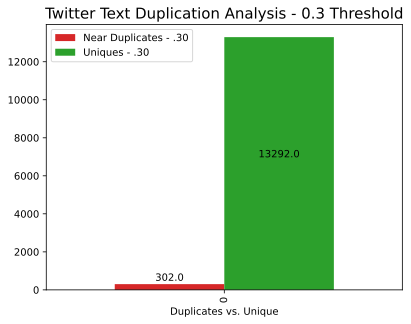

In [40]:
dups_df = pd.DataFrame.from_dict({'Near Duplicates - .30': [dups_30], 'Uniques - .30': [uniques_30]})

ax=dups_df.plot(kind = 'bar',y=['Near Duplicates - .30', 'Uniques - .30'], fontsize=10, color=['C3', 'C2'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Twitter Text Duplication Analysis - 0.3 Threshold', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [41]:
df_dups_30_tweet_text.unpersist()

distCol,id_A,id_B,tweet_text_A,tweet_text_B
0.0,7077,8679,{the university o...,{the university o...
0.19999999999999996,6363,12841,{afghanistan’s ta...,{#afghanistan's #...
0.125,1782,3007,{❔🔬 do you know...,{❔🔢 do you know...
0.1428571428571429,155,4755,{icymi: a 6-year-...,{police in the vi...
0.2857142857142857,9034,9850,{clearview at wel...,{firelands at cle...
0.0,2162,5419,{friday night spo...,{friday night spo...
0.2857142857142857,110,6936,{high school foot...,{high school foot...
0.0,7059,11736,{bay area news gr...,{bay area news gr...
0.0,3036,6272,{five takeaways f...,{five takeaways f...
0.2857142857142857,1021,9006,{virginia school ...,{school officials...


#### 0.5 Distance

In [42]:
jaccard_distance = 0.5

df_dups_tweet_text = model.approxSimilarityJoin(df_hashed_tweet_text_samp, df_hashed_tweet_text_samp, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.tweet_text').alias('tweet_text_A'),
            col('datasetB.tweet_text').alias('tweet_text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

In [43]:
df_dups_50_tweet_text = df_dups_tweet_text
df_dups_50_tweet_text.cache()
df_dups_50_tweet_text.limit(5).toPandas()

,distCol,id_A,id_B,tweet_text_A,tweet_text_B
0,0.000000,636,13088,"(opponents of school choice regularly laud traditional public schools for being ""open to all."" but they often aren't, with geographic boundaries that require hefty mortgages and property taxes or ...","(opponents of school choice regularly laud traditional public schools for being ""open to all."" but they often aren't, with geographic boundaries that require hefty mortgages and property taxes or ..."
1,0.400000,11672,12843,"(high school football: week 1 scoreboard https://t.co/eqh0ptjoay,)","(1st &amp; 10: week 10 of acadiana’s high school football [video] https://t.co/olsvjzukuq,)"
2,0.000000,1742,10127,"(florida school shooter nikolas cruz will be sentenced to life without parole for the 2018 murder of 17 people at parkland’s marjory stoneman douglas high school. \n\nhttps://t.co/bjy2sonuly,)","(florida school shooter nikolas cruz will be sentenced to life without parole for the 2018 murder of 17 people at parkland’s marjory stoneman douglas high school. https://t.co/hybgtgkma6,)"
3,0.333333,7962,8839,"(high school https://t.co/a2a0tbwnqc,)","(and that’s a sunset of high school football. https://t.co/kltovfgapo,)"
4,0.333333,7962,8618,"(high school https://t.co/a2a0tbwnqc,)","(nj high school may be site of 'cancer cluster' https://t.co/lery6xrhao,)"


In [44]:
records = df_hashed_tweet_text_samp.count()
dups_50 = df_dups_50_tweet_text.select('id_A').distinct().count()
uniques_50 = records - dups_50

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups_50)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', ': ', uniques_50)

Total records:  13594
Duplicate titles based on { 0.5 } jaccard distance:  487
Unique titles based on { 0.5 } jaccard distance:  :  13107


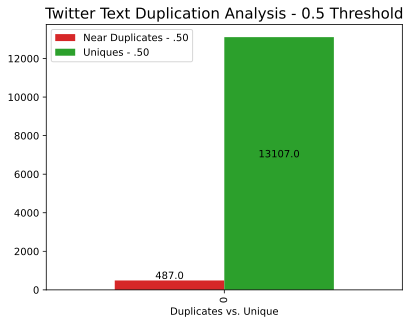

In [45]:
dups_df = pd.DataFrame.from_dict({'Near Duplicates - .50': [dups_50], 'Uniques - .50': [uniques_50]})

ax=dups_df.plot(kind = 'bar',y=['Near Duplicates - .50', 'Uniques - .50'], fontsize=10, color=['C3', 'C2'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Twitter Text Duplication Analysis - 0.5 Threshold', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [46]:
df_dups_50_tweet_text.unpersist()

distCol,id_A,id_B,tweet_text_A,tweet_text_B
0.4545454545454546,8209,12487,{acting uvalde po...,{the acting uvald...
0.4,3120,4869,{jon hamm on his ...,{week 5 high scho...
0.4545454545454546,7595,10414,{preseason all-ba...,{bay area news gr...
0.4,3120,6907,{jon hamm on his ...,{saturday’s houst...
0.4285714285714286,6123,12935,{week 12 connecti...,{houston high sch...
0.4,11672,12843,{high school foot...,{1st &amp; 10: we...
0.4285714285714286,3258,13184,{take a look at h...,{take a look at m...
0.0,6595,7657,{the best destina...,{the best destina...
0.4,4746,10038,{high school scor...,{week 11 high sch...
0.0,10839,12486,{acting uvalde po...,{acting uvalde po...


### 0.7 Distance

In [47]:
jaccard_distance = 0.7

df_dups_tweet_text = model.approxSimilarityJoin(df_hashed_tweet_text_samp, df_hashed_tweet_text_samp, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.tweet_text').alias('tweet_text_A'),
            col('datasetB.tweet_text').alias('tweet_text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

In [48]:
df_dups_70_tweet_text = df_dups_tweet_text
df_dups_70_tweet_text.cache()
df_dups_70_tweet_text.limit(5).toPandas()

,distCol,id_A,id_B,tweet_text_A,tweet_text_B
0,0.500000,965,8839,"(just one more day of texas high school football…😕\n\n#txhsfb #uilstate,)","(and that’s a sunset of high school football. https://t.co/kltovfgapo,)"
1,0.666667,7540,13155,"(middle school survey asked if students identify as 'transgender' or 'non-binary'\n\nhttps://t.co/wlhrut68ub,)","(#iranrevolution\ntehran, #iran's capital—#iranprotests against #mahsaamini's murder, day 19.\nhigh school students protest, chanting:\n""no fear! we're all together!""https://t.co/fkrcrnpxjk,)"
2,0.636364,6136,7435,"(icymi: here's what we learned from week 1 of the high school football season in the south sound 🔒\n\nhttps://t.co/zkmfryil5f,)","(how area- and state-ranked teams fared in texas high school football this week 🏈\n\n#txhsfb https://t.co/u3lglvy1uk,)"
3,0.666667,6136,7059,"(icymi: here's what we learned from week 1 of the high school football season in the south sound 🔒\n\nhttps://t.co/zkmfryil5f,)","(bay area news group high school football predictions: week 8, 2022 https://t.co/27o5blgpbo,)"
4,0.583333,6184,7110,"(great first friday night of stl high school football coverage on @ksdknews #5onyoursidelines with @ahmadhickstv and @corey_miller5 #welldone #fridaynightlights 🏈#mustseetv https://t.co/deeawn9unt,)","(high school football live updates: cif socal regional finals on friday night https://t.co/m3fv2kjpdi,)"


In [49]:
records = df_hashed_tweet_text_samp.count()
dups_70 = df_dups_70_tweet_text.select('id_A').distinct().count()
uniques_70 = records - dups_70

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups_70)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', ': ', uniques_70)

Total records:  13594
Duplicate titles based on { 0.7 } jaccard distance:  1787
Unique titles based on { 0.7 } jaccard distance:  :  11807


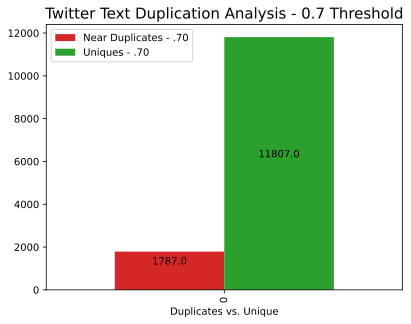

In [50]:
dups_df = pd.DataFrame.from_dict({'Near Duplicates - .70': [dups_70], 'Uniques - .70': [uniques_70]})

ax=dups_df.plot(kind = 'bar',y=['Near Duplicates - .70', 'Uniques - .70'], fontsize=10, color=['C3', 'C2'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Twitter Text Duplication Analysis - 0.7 Threshold', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [51]:
df_dups_70_tweet_text.unpersist()

distCol,id_A,id_B,tweet_text_A,tweet_text_B
0.6666666666666667,541,9025,{an annual high s...,{watch: bonfire e...
0.6666666666666667,8209,12419,{acting uvalde po...,{what did police ...
0.6666666666666667,9179,9968,{4 franklin high ...,"{about 1,000 stud..."
0.4545454545454546,8209,12487,{acting uvalde po...,{the acting uvald...
0.6666666666666667,9179,12401,{4 franklin high ...,{2 students injur...
0.6666666666666667,3120,4027,{jon hamm on his ...,{high school wres...
0.6,3120,11201,{jon hamm on his ...,{thursday's high ...
0.6666666666666667,3452,12401,{developing: des ...,{2 students injur...
0.6363636363636364,7595,10299,{preseason all-ba...,{photos: bay area...
0.5,3120,6404,{jon hamm on his ...,{here are the okl...


### Comparing side by side

In [53]:
df_dups_30_id = df_dups_30_tweet_text.select(col('id_A').alias('id_30_A'), col('id_B').alias('id_30_B'))
print(df_dups_30_id.count())

483


In [54]:
df_dups_50_id = df_dups_50_tweet_text.select(col('id_A').alias('id_50_A'), col('id_B').alias('id_50_B'))
df_dups_50_id.show(5)

+-------+-------+
|id_50_A|id_50_B|
+-------+-------+
|   8209|  12487|
|   3120|   4869|
|   7595|  10414|
|   3120|   6907|
|   6123|  12935|
+-------+-------+
only showing top 5 rows



In [55]:
df_dups_70_id = df_dups_70_tweet_text.select(col('tweet_text_A'), col('tweet_text_B'),\
                                  col('id_A').alias('id_70_A'), col('id_B').alias('id_70_B'))
df_dups_70_id.show(5)

+--------------------+--------------------+-------+-------+
|        tweet_text_A|        tweet_text_B|id_70_A|id_70_B|
+--------------------+--------------------+-------+-------+
|{this weekend mar...|{high school foot...|   4823|   5269|
|{this weekend mar...|{the tennessee hi...|   4823|  12578|
|{this weekend mar...|{ex-giant kerry c...|   4823|   6850|
|{this weekend mar...|{high school http...|   4823|   7962|
|{this weekend mar...|{the latest tn hi...|   4823|  12369|
+--------------------+--------------------+-------+-------+
only showing top 5 rows



In [56]:
dups_combined = df_dups_70_id.join(df_dups_50_id, on=((df_dups_70_id.id_70_A == df_dups_50_id.id_50_A) & (df_dups_70_id.id_70_B == df_dups_50_id.id_50_B)), how="left_outer")\
.join(df_dups_30_id, on=((df_dups_70_id.id_70_A == df_dups_30_id.id_30_A) & (df_dups_70_id.id_70_B == df_dups_30_id.id_30_B)), how="left_outer")

dups_combined.limit(5).toPandas()

,tweet_text_A,tweet_text_B,id_70_A,id_70_B,id_50_A,id_50_B,id_30_A,id_30_B
0,"(this weekend marks the end of the regular high school football season. https://t.co/c3idscccln,)","(high school https://t.co/a2a0tbwnqc,)",4823,7962,NaN,NaN,NaN,NaN
1,"(this weekend marks the end of the regular high school football season. https://t.co/c3idscccln,)","(high school football is back! https://t.co/nnn0zdq66h,)",4823,5269,NaN,NaN,NaN,NaN
2,"(this weekend marks the end of the regular high school football season. https://t.co/c3idscccln,)","(the tennessee high school football scores from week 1 of the tssaa 2022 regular season are in.\n\nhttps://t.co/azd8wcibv8,)",4823,12578,NaN,NaN,NaN,NaN
3,"(this weekend marks the end of the regular high school football season. https://t.co/c3idscccln,)",(the latest tn high school football ap rankings are out.\n\nhttps://t.co/qtpr7wjnw0\n\n@ohspatsfootball @wcsrhsfootball @caneridgefball @pagefootball @wcsnhsathletics @wcsnhspd @eastnash_fb @lam...,4823,12369,NaN,NaN,NaN,NaN
4,"(this weekend marks the end of the regular high school football season. https://t.co/c3idscccln,)","(ex-giant kerry collins now a high school football coach #nyg #giants #nfl https://t.co/kltogu7l97,)",4823,6850,NaN,NaN,NaN,NaN


In [57]:
dups_combined = dups_combined.\
withColumn("threshold_30",\
           when(col("id_30_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
withColumn("threshold_50",\
           when(col("id_50_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
withColumn("threshold_70",\
           when(col("id_70_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
drop('id_30_A', 'id_30_B', 'id_50_A', 'id_50_B', 'id_70_A', 'id_70_B')

dups_combined.limit(5).toPandas()

,tweet_text_A,tweet_text_B,threshold_30,threshold_50,threshold_70
0,"(friday night spotlight: oregon high school football week 2 scores, schedule, links https://t.co/0steze958p,)","(photos: bay area high school football week 6, 2022 https://t.co/vpa9sa7ttt,)",Non-Dup,Non-Dup,Duplicate
1,"(udaipur: students lock school gate over transfer of teacher https://t.co/lunutczj9f,)","(#iranrevolution\ntehran, #iran's capital—#iranprotests against #mahsaamini's murder, day 19.\nhigh school students protest, chanting:\n""no fear! we're all together!""https://t.co/fkrcrnpxjk,)",Non-Dup,Non-Dup,Duplicate
2,"('my son was due to graduate from kyiv university - now he's fighting the war'\nhttps://t.co/mjbgtzi4pl https://t.co/ixqzg384fq,)","(""the top uk university for graduate outcomes"" https://t.co/mkkw8l8r15 https://t.co/dbygno0plh,)",Non-Dup,Non-Dup,Duplicate
3,"(michigan kicks off its 2022 high school football season on thursday, aug. 25. https://t.co/tu0ipt7sgx,)","(tennessee high school football schedule for week 3 of tssaa 2022 season https://t.co/0juinxzhdj,)",Non-Dup,Non-Dup,Duplicate
4,"(high school football team under fire for 'blue lives matter' memorial on 9/11 https://t.co/qpl2wbf9dd,)","(robinson girls flag football best high school team in florida? https://t.co/xg1ucst0iz @robinsonflag @hillsboroughsch @buccaneers,)",Non-Dup,Non-Dup,Duplicate


In [58]:
dups_combined_sample = \
dups_combined.filter(("threshold_30 == 'Duplicate'")).sample(False, 0.1, 12345).limit(10).\
union\
(dups_combined.filter(("threshold_30 == 'Non-Dup' and threshold_50 == 'Duplicate'")).sample(False, 0.1, 12345).limit(10)).\
union\
(dups_combined.filter(("threshold_50 == 'Non-Dup'")).sample(False, 0.1, 12345).limit(10)).\
orderBy('threshold_30', 'threshold_50', 'threshold_70')

In [59]:
dups_combined_sample.limit(30).toPandas()

,tweet_text_A,tweet_text_B,threshold_30,threshold_50,threshold_70
0,"(high school scores and top performers from monday, dec. 19 https://t.co/2ljyavcopl,)","(high school scores and top performers from tuesday, feb. 7 https://t.co/jd1dodpeck,)",Duplicate,Duplicate,Duplicate
1,"(while not detailing how the distribution might be funded, gov. abbott said the medication, narcan, should be distributed to law enforcement agencies as well as some hospitals and schools. https:/...","(while not detailing how the distribution might be funded, abbott said the medication, narcan, should be distributed to law enforcement agencies as well as some hospitals and schools. https://t.co...",Duplicate,Duplicate,Duplicate
2,"(the last nizam of telangana &amp; his last order prohibited public programmes, speech, &amp; open schools. this proved to be his last dictate. likewise, kcrs's prohibitory orders are the last one...","(the last nizam of telangana &amp; his last order prohibited public programmes, speech, &amp; open schools. this proved to be his last dictate. likewise, kcrs's prohibitory orders are the last one...",Duplicate,Duplicate,Duplicate
3,"(a hardback old school manual packed with history, intelligence, technique and insight. illustrated with beautiful hand drawn images across 165 pages of knock out knowledge!\nin the uk order direc...","(a hardback old school manual packed with history, intelligence, technique and insight. illustrated with beautiful hand drawn images across 165 pages of knock out knowledge!\nin the uk order direc...",Duplicate,Duplicate,Duplicate
4,"(congratulations to these 22 high school football players who made the week 6 friday night drive team of the week https://t.co/snxrwwqyck,)","(congratulations to these 22 high school football players who made the week 8 friday night drive team of the week https://t.co/srhld2fhjq,)",Duplicate,Duplicate,Duplicate
5,"(new list of ‘best value’ colleges released: is your alma mater on it? https://t.co/fhjc8wady5,)","(new list of 'best value' colleges released: is your alma mater on it? https://t.co/ogtavua4kk,)",Duplicate,Duplicate,Duplicate
6,"(high school football week 8 area schedule https://t.co/paayqndtlz,)","(photos: bay area high school football week 6, 2022 https://t.co/vpa9sa7ttt,)",Duplicate,Duplicate,Duplicate
7,"(mom sues fla. schools, claiming district banned her over onlyfans posts\nhttps://t.co/qhxlwvzgll,)","(mom sues florida schools, claiming district banned her over onlyfans posts https://t.co/xu53qot5je,)",Duplicate,Duplicate,Duplicate
8,"(a teenager accused of killing four fellow students and injuring more at a michigan high school is expected to plead guilty to murder next week, authorities said friday. https://t.co/iqt1f1qadw,)","(a teenager accused of killing four fellow students and injuring more at a michigan high school is expected to plead guilty to murder next week, authorities said friday.\n\nhttps://t.co/symnj4yni3,)",Duplicate,Duplicate,Duplicate
9,"(eastern massachusetts high school scores and highlights from wednesday https://t.co/il2rqvxwe7,)","(eastern massachusetts high school scores and highlights from friday https://t.co/xbhyugoni6,)",Duplicate,Duplicate,Duplicate


### Because of verified posts, the duplicity between tweets was low. A Jaccard distance of 0.5 was employed to find near duplicates using count-vectorizer and locality sensitive hashing